In [1]:
##########################################################
# パッケージの読み込みとエイリアスの設定
##########################################################
using Revise, LinearAlgebra, LaTeXStrings, Plots, CSV, DataFrames, JLD2, Random, Statistics, Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC

In [2]:
function tci_oneshot(func, d, localdims, firstpivot, tol, maxiter)
    BLAS.set_num_threads(4)
    #func_q = GenNDfunc(d, func)

    for isearch in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot) # search optimal fist pivot
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end

    # execute tci2
    qtt, ranks, errors = TCI.crossinterpolate2(
        Float64,
        func, 
        localdims, 
        [firstpivot], 
        tolerance = tol, 
        maxiter = maxiter, 
        verbosity = 1, 
        loginterval = 1,
        pivotsearch = :full,
        # normalizeerror = false,
    )

    return qtt, errors
end  

tci_oneshot (generic function with 1 method)

In [3]:
##########################################################
# パラメータの設定とグリッド生成
##########################################################

#T = 1.0
#S0K = 110.0
#r = 0.05



Random.seed!(1234)
# d_normals = randn(Float64, N_STEPS * N_PATHS)

num_nodes = 64
index_ = Int(num_nodes/2)

S0K_values = TCIMC.calc_cheby_abscissas(90.0, 120.0, num_nodes)
implied_vol_values = TCIMC.calc_cheby_abscissas(0.15, 0.25, num_nodes)
T_value = 1.0
r_value = 0.01
t_value = 0.5

0.5

$$
d_{1/2} = \frac{\ln{(S_0 / K)} + (r \pm \sigma^2 / 2)(T-t)}{\sigma \sqrt{T-t} }
$$

In [4]:
d1(S0K::Float64, σ::Float64, r::Float64, T::Float64, t::Float64) = (log(S0K) + (r + σ^2/2) * (T - t)) / (σ * (T - t)^2)

function d1_ind_pre(
    bits::Vector{Int}, 
    S0K_values, 
    implied_vol_values, 
    T_value, 
    r_value, 
    t_value
    )
    S0K = S0K_values[bits[1]]
    σ = implied_vol_values[bits[2]]
    return d1(S0K, σ, r_value, T_value, t_value)
end 

d1_ind(bits) = d1_ind_pre(bits, S0K_values, implied_vol_values, T_value, r_value, t_value)

d1_ind (generic function with 1 method)

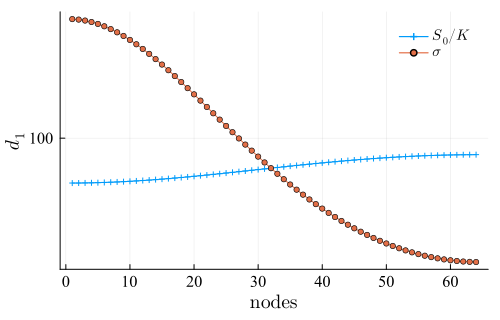

In [5]:
plot_d1 = plot(
    # yscale = :log,
    # xscale = :log,
    # title = L"\mathrm{QTT}~,~~d=10",
    xlabel = L"\mathrm{nodes}",
    ylabel = L"d_1",
    #markershape = :circle,
    titlefontsize = 17,
    legendfontsize = 10,
    tickfontsize = 10,
    xguidefont = 13,
    yguidefont = 13,
    #xlims = (0.6, 3.5),
    #xticks = 1:1:nbit*d-1,
    # ylims = (1, 2^(nbit*d*0.5)),
    yticks = [10^0, 10^2, 10^4, 10^6, 10^8],
    # legend = :inside,
    #size = (600, 450),
    #bottom_margin=Plots.Measures.Length(:mm, 3.0),
    bottom_margin=Plots.Measures.Length(:mm, 2.0),
    fontfamily = "Times New Roman",
    size = (500, 320),
    foreground_color_legend = nothing,
    background_color_legend = nothing,
)

plot!(
    plot_d1,
    [d1_ind([S0K_ind, index_, index_, index_, index_]) for S0K_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"S_0 / K",
)

plot!(
    plot_d1,
    [d1_ind([index_, σ_ind, index_, index_, index_]) for σ_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"\sigma",
)

In [6]:
##########################################################
# TCI のキャッシュ関数設定とワンショット補間の実行
##########################################################
# 関数 abo は asian_barrier_option_tci のラッパー（引数はインデックス）
#abo(j) = asian_barrier_option_tci(j, price_matrix_mc)
# abo_(j) = asian_barrier_option_tci(j, price_matrix_mc)

d = 2
localdims_d1 = fill(num_nodes, d)
firstpivot_d1 = rand(1:num_nodes, d)
d1_cf = TCI.CachedFunction{Float64}(d1_ind, localdims_d1)
tol_mc = 1e-5
tol = tol_mc
maxiter = 10

tci_time = @elapsed begin
    tt_tci, errors_asianbarrier = tci_oneshot(d1_cf, d, localdims_d1, firstpivot_d1, tol, maxiter)
end

##########################################################

Found 0 global pivots
iteration = 1, rank = 2, error= 3.5624714983528705e-14, maxsamplevalue= 127.93596199730678, nglobalpivot=0
Found 0 global pivots
iteration = 2, rank = 2, error= 3.5624714983528705e-14, maxsamplevalue= 127.93596199730678, nglobalpivot=0
Found 0 global pivots
iteration = 3, rank = 2, error= 3.5624714983528705e-14, maxsamplevalue= 127.93596199730678, nglobalpivot=0


9.564968936

In [7]:
# TCI後のTTを評価
n = num_nodes
price_matrix_tci_S0K = zeros(n)
price_matrix_ex_S0K = zeros(n)
price_matrix_tci_sigma = zeros(n)
price_matrix_ex_sigma = zeros(n)

for i in 1:n
    price_matrix_tci_S0K[i] = TCIMC._evaluate(tt_tci.sitetensors, [i, index_, index_, index_, index_])
    price_matrix_ex_S0K[i] = d1_ind([i, index_, index_, index_, index_])
    price_matrix_tci_sigma[i] = TCIMC._evaluate(tt_tci.sitetensors, [index_, i, index_, index_, index_])
    price_matrix_ex_sigma[i] = d1_ind([index_, i, index_, index_, index_])
end

ab_error_S0K = abs.(price_matrix_tci_S0K .- price_matrix_ex_S0K)
ab_error_sigma = abs.(price_matrix_tci_sigma .- price_matrix_ex_sigma)
rel_error_S0K = abs.(price_matrix_tci_S0K .- price_matrix_ex_S0K) ./ price_matrix_ex_S0K
rel_error_sigma = abs.(price_matrix_tci_sigma .- price_matrix_ex_sigma) ./ price_matrix_ex_sigma


println("==== TCI ====")
println("Max absolute error for S0K    : ", maximum(ab_error_S0K))
println("Max absolute error for sigma  : ", maximum(ab_error_sigma))
println("Max relative error for S0K    : ", maximum(rel_error_S0K))
println("Max relative error for sigma  : ", maximum(rel_error_sigma))
:

==== TCI ====
Max absolute error for S0K    : 1.4210854715202004e-14
Max absolute error for sigma  : 1.4210854715202004e-14
Max relative error for S0K    : 1.5640346057043529e-16
Max relative error for sigma  : 1.8986031195379883e-16


(::Colon) (generic function with 30 methods)

In [8]:
TCI.TensorTrain(tt_tci)

(::TensorTrain{Float64, 3}) (generic function with 1 method)

In [9]:
M_dct = TCIMC.dct_matrix(n)
C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_tci), fill(M_dct, d))
#C_coeff_tensor_svd = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_svd), fill(M_dct, 2))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

### 不明点

In [17]:
using Statistics, Random

#num_nodes = n
# num_nodes_S0 = 300
num_nodes_cheby = 64
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_cheby))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_cheby))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
# all_idx_pairs = [(i, j, k, l, m) for i in 1:num_nodes, j in 1:num_nodes, k in 1:num_nodes, l in 1:num_nodes, m in 1:num_nodes]
all_idx_pairs = collect(Iterators.product(1:num_nodes_cheby, 1:num_nodes_cheby))
rand_idx_pairs = rand(vec(all_idx_pairs), 2)

# 解析解の関数
d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv, T_value, r_value, t_value)
#d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values, implied_vol_values, T_values, r_values, t_values)


price_dict_tci = Dict{NTuple{2, Int}, Float64}()
price_dict_ex = Dict{NTuple{2, Int}, Float64}()

for (i, j) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]

    weights = [
        TCIMC.chebyshev_basis(90.0, 120.0, s0_val, num_nodes_cheby),
        TCIMC.chebyshev_basis(0.15, 0.25, vol_val, num_nodes_cheby),
    ]

    c = 1  # 初期コアから更新
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    # TCI
    price_dict_tci[(i, j)] = result_original
    # 解析解
    price_dict_ex[(i, j)] = d1_ind_ex([i, j])
end



In [18]:
@show price_dict_ex
@show price_dict_tci
;

price_dict_ex = Dict((56, 21) => 104.94839947297605, (9, 36) => 88.67344194707447)
price_dict_tci = Dict((56, 21) => 104.94839947297628, (9, 36) => 88.67344194707448)


### 誤差評価

In [19]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    tci_val = price_dict_tci[key]
    
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

@show abs_error_vals
@show rel_error_vals

println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals))
println("Max  relative error   : ", maximum(rel_error_vals))

abs_error_vals = [2.2737367544323206e-13, 1.4210854715202004e-14]
rel_error_vals = [2.1665282804220394e-15, 1.6026055156045346e-16]
==== cheby ====
Mean absolute error   : 1.2079226507921703e-13
Max  absolute error   : 2.2737367544323206e-13
Mean relative error   : 1.1633944159912465e-15
Max  relative error   : 2.1665282804220394e-15
